In [480]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None

Quick Visualisation of the Training Data

In [481]:
def clean_data(raw_df):
    mask = (raw_df[0].str.count(':') == 1) & (raw_df[0].str.count('#') == 1)  
    data = raw_df[mask]
    data[0] = data[0].str.replace('#','.')
    data['Type'] = data.loc[:, 0].str.split(':').str[0].str.strip()
    data['Value'] = data.loc[:, 0].str.split(':').str[1]
    data['Value'] = pd.to_numeric(data['Value'])
    data['Time'] = data.index
    data.drop(0,axis=1,inplace=True)

    return data

In [482]:
def type_mask(data,types_arr):
    mask = data['Type'].str.contains(types_arr[0])
    for i in range(1, len(types_arr)):
        mask = mask | (data['Type'].str.contains(types_arr[i]))
    return mask

['Supervisor Ball Distance' 'Supervisor Ball Angle' 'distance estimate'
 'angle' 'ball width' 'ball height' 'x1' 'y1' 'x2' 'y2' 'score']


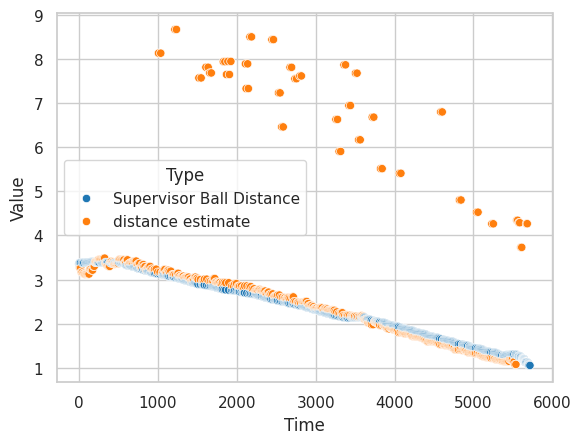

['Supervisor Ball Distance' 'Supervisor Ball Angle' 'angle' 'ball width'
 'ball height' 'x1' 'y1' 'x2' 'y2' 'score' 'distance estimate']


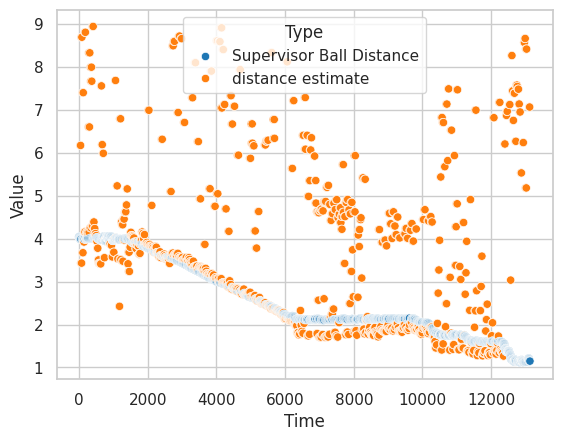

In [483]:
for test in ['data/final.csv','data/final2.csv']:
    test = pd.read_csv(test,header=None)
    test = clean_data(test)
    print(test['Type'].unique())
    sns.set(style="whitegrid")
    #mask = (test['Type'].str.contains('Supervisor Ball D') | test['Type'].str.contains('distance estimate') or test['Type'].str.contains('Supervisor Ball A'))
    mask = type_mask(test,['Supervisor Ball D','distance estimate'])
    filtered_data = test[mask]
    sns.scatterplot(x='Time', y='Value', hue='Type', data=filtered_data, palette='tab10')
    plt.show()


Now setting up the data to train a multivariate linear regression

In [484]:
def get_np_data(df):
    df = clean_data(df)
    window_size = len(df['Type'].unique())
    df = df.pivot(index='Time', columns='Type', values='Value')
    window_size = window_size
    df.fillna(-1000, inplace=True)
    averaged_df = df.rolling(window_size,step=window_size).max()
    averaged_df[averaged_df < -500] = np.nan
    averaged_df = averaged_df.dropna()
    labels = averaged_df.columns
    np_data = averaged_df.to_numpy()
    return labels, np_data


In [485]:
test1 = pd.read_csv('data/final.csv',header=None)
test2 = pd.read_csv('data/final2.csv',header=None)
for test in [test1,test2]:
    labels, np_data = get_np_data(test)
    print(labels)
    np_data.shape

Index(['Supervisor Ball Angle', 'Supervisor Ball Distance', 'angle',
       'ball height', 'ball width', 'distance estimate', 'score', 'x1', 'x2',
       'y1', 'y2'],
      dtype='object', name='Type')
Index(['Supervisor Ball Angle', 'Supervisor Ball Distance', 'angle',
       'ball height', 'ball width', 'distance estimate', 'score', 'x1', 'x2',
       'y1', 'y2'],
      dtype='object', name='Type')


In [486]:
predict_angle = False
if predict_angle:
    u = 0
else:
    u = 1

_,np_data = get_np_data(test1)
X1 = np_data[:,7:]
y1 = np_data[:,u]
print(X1.shape, y1.shape)
_,np_data = get_np_data(test2)
X2 = np_data[:,7:]
y2 = np_data[:,u]
print(X2.shape, y2.shape)
X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2))
print(X.shape, y.shape)

(402, 4) (402,)
(662, 4) (662,)
(1064, 4) (1064,)


Multivariate Linear Regression

In [487]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


degree = 1
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)  

param_grid = {'fit_intercept': [True, False]} 

grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train) 

linear_model = grid_search.best_estimator_
y_pred = linear_model.predict(X_test_scaled) 

print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R-squared:', r2_score(y_test, y_pred))
print('Best parameters:', grid_search.best_params_) 


Mean Squared Error: 0.37443947759622404
R-squared: 0.4017276503784374
Best parameters: {'fit_intercept': True}


Text(0, 0.5, 'Predictions')

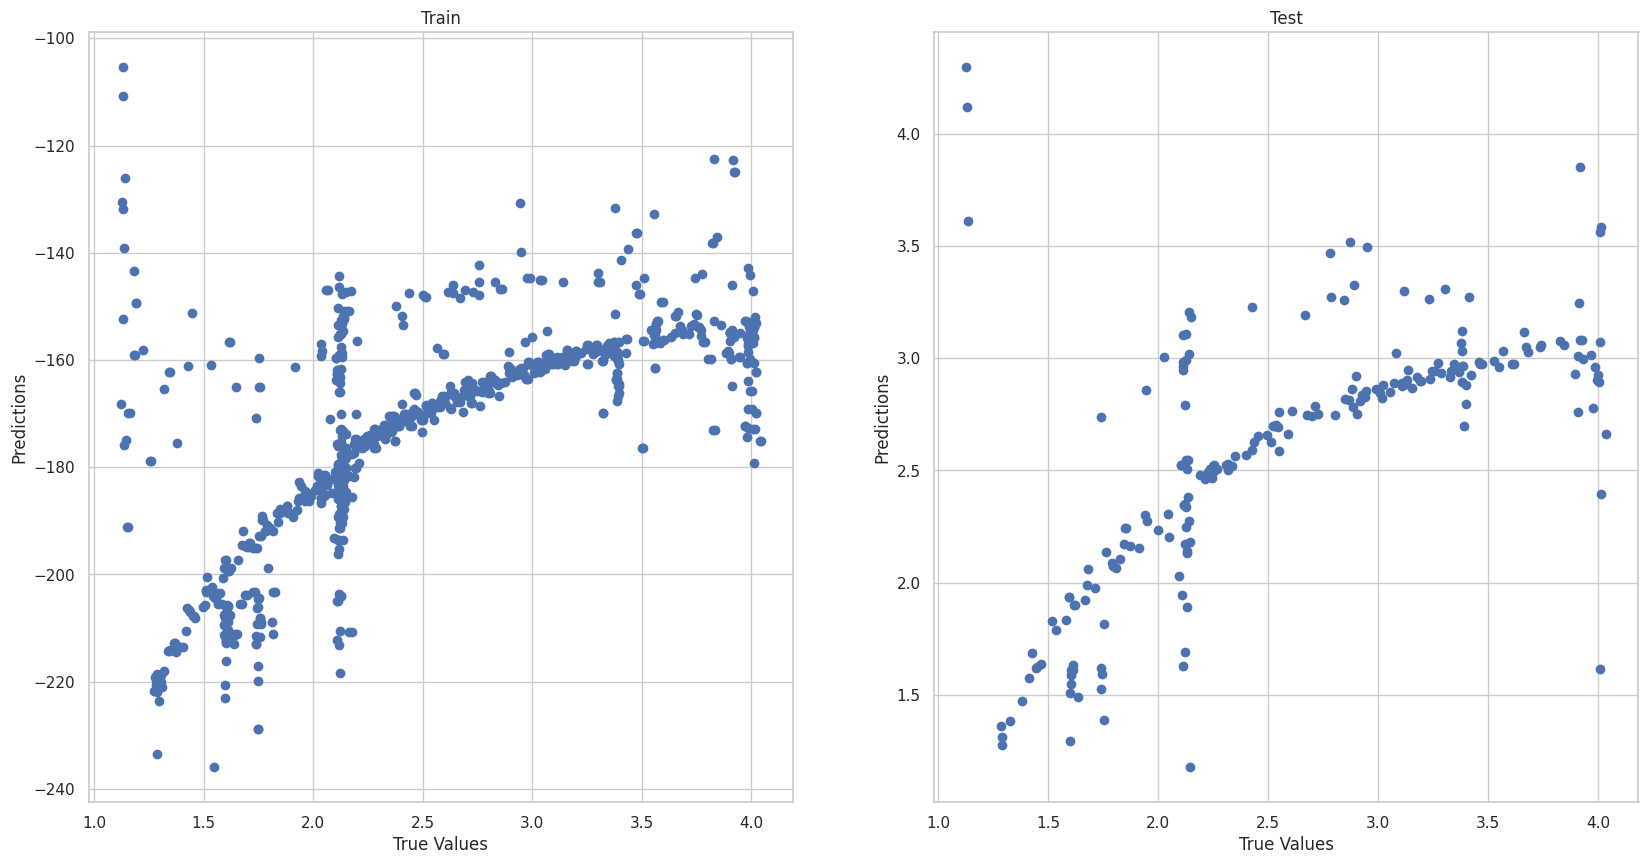

In [488]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Train')
plt.scatter(y_train, linear_model.predict(X_train))
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.subplot(1,2,2)
plt.title('Test')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')


In [489]:
coefficients = linear_model.coef_
feature_names = labels[7:]
importance = np.abs(coefficients)

feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importance.sort_values(by='importance', ascending=False)


,feature,importance
2,y1,0.503066
3,y2,0.048157
1,x2,0.033823
0,x1,0.031695


Random Trees

In [490]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


degree = 1
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)  

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, None] 
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train) 


forest_model = grid_search.best_estimator_
y_pred = forest_model.predict(X_test_scaled) 

print('Mean Squared Error (with Random Forest):', mean_squared_error(y_test, y_pred))
print('R-squared (with Random Forest):', r2_score(y_test, y_pred))
print('Best parameters:', grid_search.best_params_) 


Mean Squared Error (with Random Forest): 0.11005191661120498
R-squared (with Random Forest): 0.8326190700636376
Best parameters: {'max_depth': None, 'n_estimators': 200}


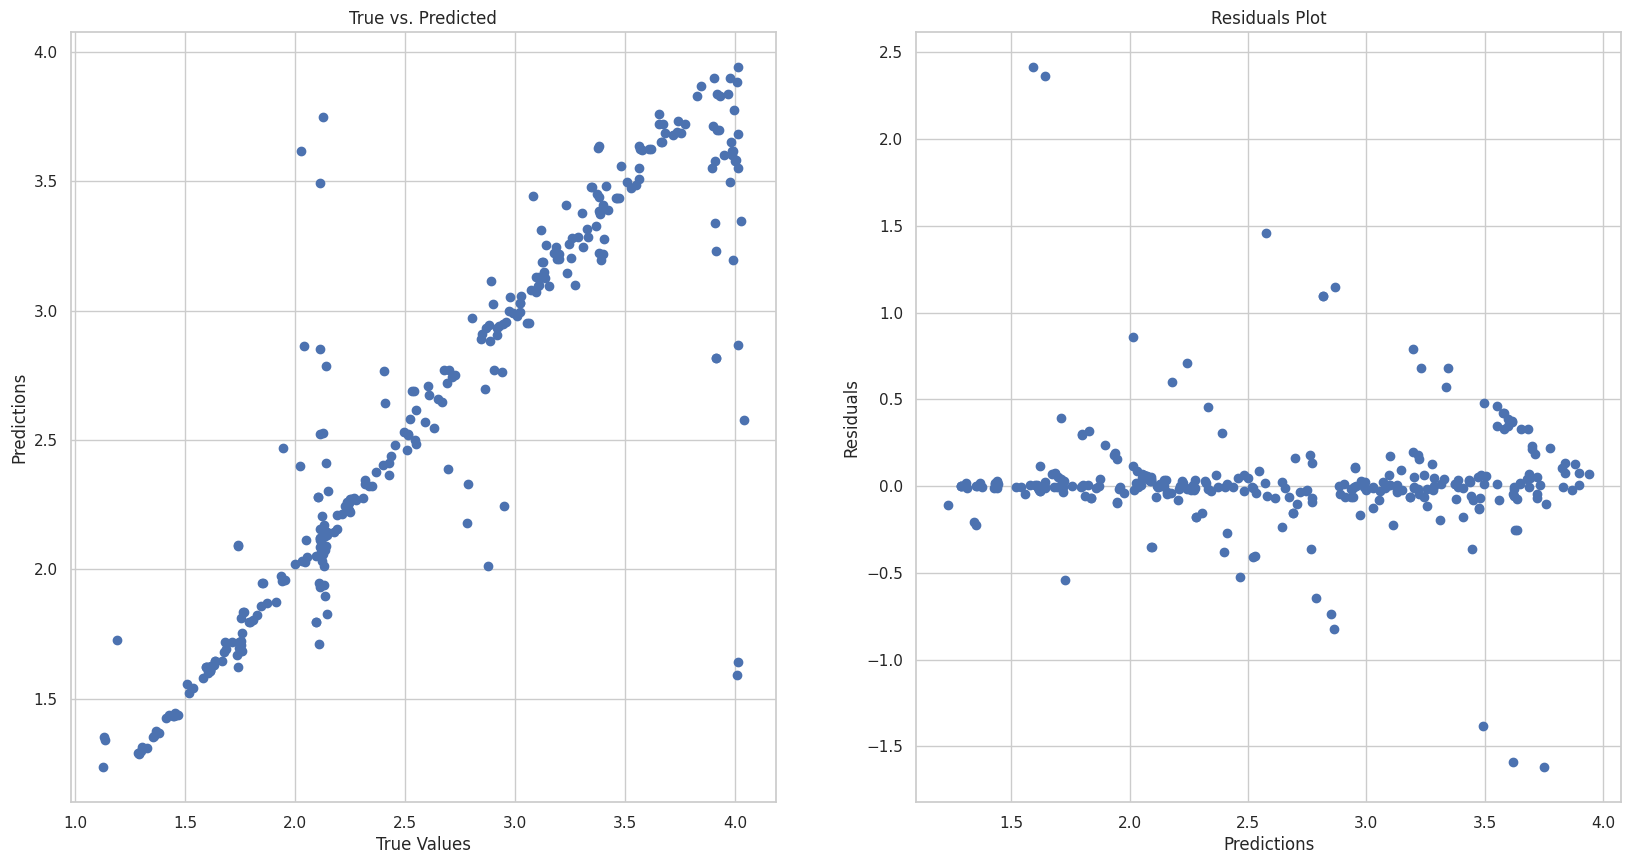

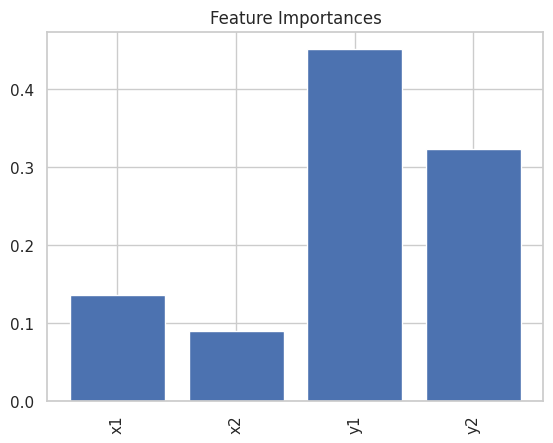

In [491]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals Plot')



feature_importances = forest_model.feature_importances_
feature_names = labels[7:]
plt.bar(feature_names, feature_importances)
plt.xticks(rotation='vertical')
plt.title('Feature Importances')


